# Plot experiment results

In [1]:
import collections
import os
import json
import pathlib

import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import numpy as np
import pandas as pd


PATH_RESOURCES = "../segmenter_checkpoint"
OUTPUT_DIR = "./figures"


pathlib.Path(OUTPUT_DIR).mkdir(exist_ok=True, parents=True)


sns.set_theme(
    context="paper",
    style="whitegrid",
    palette="colorblind",
    font_scale=1.5,
)

def all_cls_attrs(attr: str) -> list[str]:
    return [f"{attr}_{i}" for i in range(4)]

In [2]:
df = []

for layer_count in (2, 4, 6, 8, 10, 12):
    try:
        file_uri = os.path.join(PATH_RESOURCES, f"{layer_count}_layer_model", "all_results.json")
        with open(file_uri, "r") as f:
            df_col = pd.DataFrame.from_dict({layer_count: json.load(f)}, orient="index")
    
    except FileNotFoundError:
        continue
        
    df.append(df_col)

    
df = pd.concat(df).T
df

,2,4,6,8,10,12
epoch,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000
test_loss,0.004714,0.003769,0.003804,0.003832,0.004186,0.004484
test_macro_f1,0.913440,0.928159,0.926896,0.924110,0.916481,0.905569
test_macro_precision,0.957586,0.956748,0.950410,0.939381,0.943016,0.948708
test_macro_recall,0.873184,0.901230,0.904519,0.909327,0.891398,0.866183
test_overall_accuracy,0.998697,0.998939,0.998900,0.998890,0.998818,0.998655
test_per_cls_precision_0,0.999279,0.999427,0.999385,0.999395,0.999338,0.999240
test_per_cls_precision_1,0.981373,0.984958,0.985567,0.986052,0.985057,0.981299
test_per_cls_precision_2,0.953663,0.963052,0.962023,0.957671,0.953813,0.957592
test_per_cls_precision_3,0.896030,0.879556,0.854663,0.814404,0.833854,0.856702


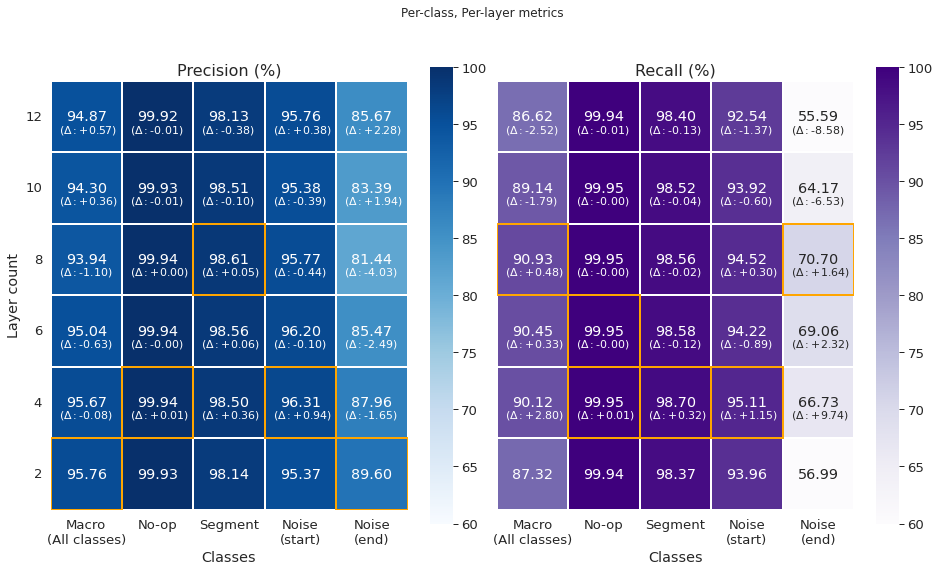

In [3]:
height = 8.4
width = 8

scale = 100.

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(2 * width, height), sharex=True, sharey=True)

ax_aspect = "equal"
ax1.set_aspect(ax_aspect)
ax2.set_aspect(ax_aspect)

rotation = 0
xticklabels = ["Macro\n(All classes)", "No-op", "Segment", "Noise\n(start)", "Noise\n(end)"]
yticklabels = df.columns

conf_heatmap = dict(
    square=True,
    linewidths=1.75,
    robust=True,
    xticklabels=xticklabels,
    yticklabels=yticklabels,
    fmt="",
    vmax=scale * 1.0,
    vmin=scale * 0.6,
    cbar_kws=dict(),
)


fig.suptitle("Per-class, Per-layer metrics", fontsize=12)

subset_1 = scale * df.loc[["test_macro_precision", *all_cls_attrs("test_per_cls_precision")]]
subset_2 = scale * df.loc[["test_macro_recall", *all_cls_attrs("test_per_cls_recall")]]


def build_annot(ax, subset):
    max_vals = subset.values.max(axis=0)
    annot = np.full_like(subset.values, fill_value=None, dtype=object)
    
    n, m = subset.shape
    
    for i in range(n):
        for j in range(m):
            annot[i, j] = f"{subset.values[i, j]:.2f}"
            if np.isclose(subset.values[i, j], max_vals[j]):
                annot[i, j] = f"{annot[i, j]}"
    
    return annot


def add_cell_highlight(ax, subset):
    max_vals = subset.values.max(axis=0)
    
    n, m = subset.shape
    
    for i in range(n):
        for j in range(m):
            if np.isclose(subset.values[i, j], max_vals[j]):
                rect = plt.Rectangle(
                    xy=(j, i),
                    width=1,
                    height=1,
                    edgecolor="orange",
                    fill=False,
                    lw=2,
                    linestyle="solid",
                )
                ax.add_patch(rect)


def apply_delta_annot(ax, subset):
    n, m = subset.shape
    
    cols = np.full_like(subset, fill_value=None, dtype=object)
    
    children = [child for child in ax.get_children() if isinstance(child, plt.Text)]
    
    for i in range(n):
        for j in range(m):
            cols[i, j] = children[i * m + j].get_color()
    
    for i in range(1, n):
        for j in range(m):
            dlt_val = subset.values[i, j] - subset.values[i - 1, j]
            sign = "+" if dlt_val >= 0 else "-"
            ax.annotate(
                f"\n($\Delta:${sign}{abs(dlt_val):.2f})",
                xy=(j, i),
                xytext=(8, 20),
                color=cols[i, j],
                fontsize=11,
                textcoords='offset points',
            )
            
hm_1 = sns.heatmap(subset_1.T, ax=ax1, **conf_heatmap, annot=build_annot(ax1, subset_1.T), cmap="Blues")
hm_1.set_xlabel("Classes")
hm_1.set_ylabel("Layer count")
hm_1.set_title("Precision (%)", fontsize=16)

hm_2 = sns.heatmap(subset_2.T, ax=ax2, **conf_heatmap, annot=build_annot(ax2, subset_2.T), cmap="Purples")
hm_2.set_xlabel("Classes")
hm_2.set_title("Recall (%)", fontsize=16)

add_cell_highlight(ax1, subset_1.T)
add_cell_highlight(ax2, subset_2.T)

ax1.set_xticklabels(labels=xticklabels, rotation=rotation)
ax1.set_yticklabels(labels=yticklabels, rotation=rotation)
ax1.invert_yaxis()

apply_delta_annot(ax1, subset_1.T)
apply_delta_annot(ax2, subset_2.T)

fig.subplots_adjust(wspace=0.0, hspace=0.0)

fig.savefig(
    fname=os.path.join(OUTPUT_DIR, "heatmap_precision_recall.pdf"),
    transparent=True,
    format="pdf",
)

# Using trained models in a few unseen examples

In [ ]:
import pandas as pd
import colorama

import segmentador


seg_model = segmentador.Segmenter(
    uri_model="../pretrained_segmenter_model/6_layer_model",
    init_from_pretrained_weights=True,
    device="cpu",
)

# seg_model.model.config

In [ ]:
df = pd.read_csv(
    "/media/hdd/master/data/proposicao-tema-extra.csv",
    header=0,
    usecols=["imgArquivoTeorPDF"],
).squeeze(True)

df.dropna(inplace=True)
df.drop_duplicates(inplace=True)

non_noise_inds = [i for i, text in enumerate(df) if set("˜ˇˆˇˇˆ").isdisjoint(text)]

df = df.iloc[non_noise_inds]

print(df.shape)

In [ ]:
id_ = -3

segments_a = seg_model(
    df.iloc[id_],
    return_justificativa=False,
    double_pass_block_intersection=False,
)

segments_b = seg_model(
    df.iloc[id_],
    return_justificativa=False,
    double_pass_block_intersection=True,
)

i = j = 0
diff_a_b = set(segments_a) - set(segments_b)
diff_b_a = set(segments_b) - set(segments_a)

while i < len(segments_a) or j < len(segments_b):
    print(end=colorama.Fore.YELLOW)
    
    if i >= len(segments_a):
        print("A: --")
        print("B:", segments_b[j], end="\n\n")
        j += 1
        continue
    
    if j >= len(segments_b):
        print("A:", segments_a[i])
        print("B: --", end="\n\n")
        i += 1
        continue
    
    if segments_a[i] in diff_a_b:
        print("A:", segments_a[i])
        print("B: --", end="\n\n")
        i += 1
        continue
    
    if segments_b[j] in diff_b_a:
        print("A: --")
        print("B:", segments_b[j], end="\n\n")
        j += 1
        continue
        
    print(end=colorama.Style.RESET_ALL)
    print("A:", segments_a[i])
    print("B:", segments_b[j], end="\n\n")
    i += 1
    j += 1

In [ ]:
id_ = -1
return_justificativa = True

print(colorama.Fore.RED, "+-----------------------------+", colorama.Style.RESET_ALL, sep="", end="\n")
print(colorama.Fore.RED, "|        Original Text:       |", colorama.Style.RESET_ALL, sep="", end="\n")
print(colorama.Fore.RED, "+-----------------------------+", colorama.Style.RESET_ALL, sep="", end="\n\n")

print(df.iloc[id_])

segments, justificativa = seg_model(
    df.iloc[id_],
    return_justificativa=return_justificativa,
)

print(colorama.Fore.YELLOW, "+-----------------------------+", colorama.Style.RESET_ALL, sep="", end="\n")
print(colorama.Fore.YELLOW, "|     Segmentation Result:    |", colorama.Style.RESET_ALL, sep="", end="\n")
print(colorama.Fore.YELLOW, "+-----------------------------+", colorama.Style.RESET_ALL, sep="", end="\n\n")

for i, seg in enumerate(segments, 1):
    print(f"{colorama.Fore.WHITE + str(i) + colorama.Style.RESET_ALL}: {seg}", end="\n\n")
    
print(colorama.Fore.BLUE, "+-----------------------------+", colorama.Style.RESET_ALL, sep="", end="\n")
print(colorama.Fore.BLUE, "|        Justificativa:       |", colorama.Style.RESET_ALL, sep="", end="\n")
print(colorama.Fore.BLUE, "+-----------------------------+", colorama.Style.RESET_ALL, sep="", end="\n\n")

if return_justificativa:
    print(justificativa)